## Binary classification with Logistic regression 

### import libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import getpass

### connection to sql 

In [2]:
mysqlpassword = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + mysqlpassword + '@localhost/bank'
engine = create_engine(connection_string)

In [3]:
df=pd.read_sql_query('''
select l.loan_id, l.status, count(distinct t.trans_id) as nooftrans,
datediff(19981231, convert(a.date, date)) as ageofaccount, 
d.A12 as 95unemp, d.A13 as 96unemp, dp.type,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid,
t.k_symbol as trans_type
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, datediff(19981231, convert(a.date, date)),
 dp.type, round((l.amount-l.payments)/l.amount,2), t.k_symbol
''', engine)


### EDA - exploratory data analysis - get to know the data 

In [4]:
df.head(20)


,loan_id,status,nooftrans,ageofaccount,95unemp,96unemp,type,loanamount,birth_number,crime95,crime96,ratiopaid,trans_type
0,4959,A,191,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,
1,4959,A,32,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,SIPO
2,4959,A,65,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,SLUZBY
3,4959,A,70,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,UROK
4,4959,A,16,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,UVER
5,4961,B,89,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,
6,4961,B,8,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SANKC. UROK
7,4961,B,26,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SIPO
8,4961,B,40,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SLUZBY
9,4961,B,90,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,UROK


In [37]:
df.info()

<bound method DataFrame.info of          status  nooftrans  ageofaccount  95unemp  96unemp  loanamount  \
0     goodloans        191          2134     0.29     0.43       80952   
1     goodloans         32          2134     0.29     0.43       80952   
2     goodloans         65          2134     0.29     0.43       80952   
3     goodloans         70          2134     0.29     0.43       80952   
4     goodloans         16          2134     0.29     0.43       80952   
...         ...        ...           ...      ...      ...         ...   
3377  goodloans         22          1174     5.77     6.55      129408   
3378  goodloans         18          1174     5.77     6.55      129408   
3379  goodloans         33          1174     5.77     6.55      129408   
3380  goodloans         38          1174     5.77     6.55      129408   
3381  goodloans         12          1174     5.77     6.55      129408   

      birth_number  ratiopaid  trans_type  crime_sum  
0           450204      

In [6]:
df.describe()

,loan_id,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
count,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000
mean,6165.832643,46.150503,1224.512123,2.872915,3.536996,151247.219397,583167.102011,14726.410704,16439.907451,0.962454
std,683.364451,49.217703,518.318978,1.889644,2.142543,114452.365902,127444.909748,27012.241517,31361.201323,0.022097
min,4959.000000,1.000000,374.000000,0.000000,0.430000,4980.000000,350129.000000,0.000000,888.000000,0.920000
25%,5568.000000,15.000000,808.250000,1.510000,1.960000,66432.000000,471210.000000,2159.000000,2305.000000,0.960000
50%,6169.000000,29.000000,1074.000000,2.770000,3.490000,116040.000000,581007.000000,3729.000000,3868.000000,0.970000
75%,6750.250000,59.000000,1684.000000,3.850000,4.790000,212400.000000,690119.000000,6949.000000,6872.000000,0.980000
max,7308.000000,330.000000,2178.000000,7.340000,9.400000,590820.000000,806207.000000,85677.000000,99107.000000,0.980000


In [7]:
df.birth_number.unique()

array([450204, 395423, 620209, 520826, 405130, 445613, 420128, 670921,
       506227, 530126, 455703, 391130, 670924, 446025, 711019, 400827,
       565105, 735108, 395517, 745630, 735526, 476019, 650731, 471008,
       370601, 610724, 655803, 575927, 415519, 605719, 665309, 565322,
       421210, 405212, 455924, 565913, 520803, 701218, 510806, 570217,
       556119, 610930, 600628, 480521, 775510, 545316, 715826, 350129,
       406126, 585915, 586230, 666002, 755901, 440506, 455612, 361127,
       505313, 791027, 566218, 636231, 686220, 516129, 460122, 715625,
       425419, 625306, 466017, 601222, 441215, 390929, 411111, 670907,
       570429, 401125, 465701, 655818, 455317, 510724, 755912, 620905,
       680415, 695313, 575122, 371213, 400607, 505926, 430312, 405724,
       510906, 535720, 495516, 475722, 680722, 741022, 425913, 521212,
       405420, 505102, 665410, 790325, 575823, 570919, 700325, 481218,
       550521, 635125, 765609, 371028, 391206, 430614, 755128, 710106,
      

In [8]:
df['status'].value_counts()

C    1954
A    1001
D     252
B     175
Name: status, dtype: int64

In [9]:
def status_group(x):
    if x in ['B', 'D']:
        return 'badloans'
    else:
        return 'goodloans'

In [10]:
df['status'] = list(map(status_group, df['status']))

In [11]:
df.head(20)

,loan_id,status,nooftrans,ageofaccount,95unemp,96unemp,type,loanamount,birth_number,crime95,crime96,ratiopaid,trans_type
0,4959,goodloans,191,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,
1,4959,goodloans,32,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,SIPO
2,4959,goodloans,65,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,SLUZBY
3,4959,goodloans,70,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,UROK
4,4959,goodloans,16,2134,0.29,0.43,OWNER,80952,450204,85677,99107,0.96,UVER
5,4961,badloans,89,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,
6,4961,badloans,8,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SANKC. UROK
7,4961,badloans,26,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SIPO
8,4961,badloans,40,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,SLUZBY
9,4961,badloans,90,1364,1.51,2.07,OWNER,30276,395423,2299,2354,0.92,UROK


In [12]:
df['trans_type'].value_counts()

SLUZBY         682
UROK           682
UVER           674
               643
SIPO           468
POJISTNE       114
SANKC. UROK     80
                39
Name: trans_type, dtype: int64

### histograms or boxplots



<AxesSubplot:xlabel='nooftrans', ylabel='Count'>

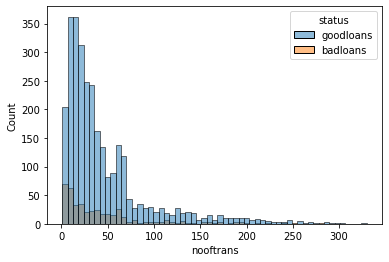

In [13]:
sns.histplot(df, x='nooftrans', hue='status')

<AxesSubplot:xlabel='trans_type', ylabel='Count'>

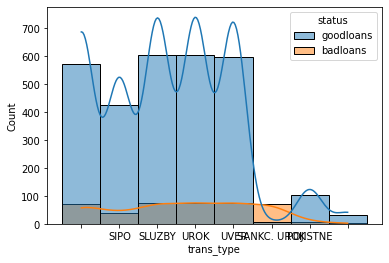

In [14]:
sns.histplot(df, x='trans_type', hue='status', kde=True)

<AxesSubplot:xlabel='loanamount', ylabel='status'>

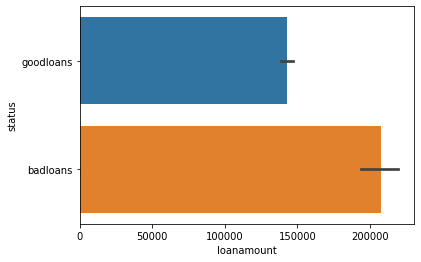

In [15]:
sns.barplot(x='loanamount', y='status', data=df)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ageofaccount', ylabel='Density'>

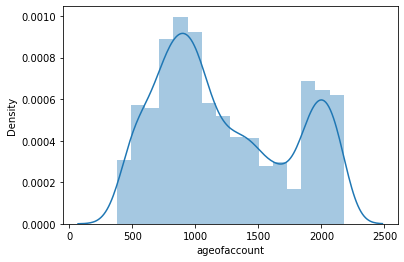

In [16]:
sns.distplot(df['ageofaccount'])

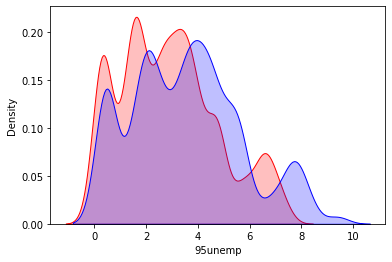

In [17]:
fig = sns.kdeplot(df['95unemp'], shade=True, color="r")
fig = sns.kdeplot(df['96unemp'], shade=True, color="b")
plt.show()

### Check for multicollinearity 

In [18]:

correlation = df.corr()
correlation


,loan_id,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
loan_id,1.000000,0.053192,0.056562,-0.079593,-0.088409,-0.037135,0.125244,0.102541,0.102344,0.013233
nooftrans,0.053192,1.000000,0.428359,-0.014224,-0.019200,-0.036264,0.022545,0.028787,0.028605,-0.043902
ageofaccount,0.056562,0.428359,1.000000,-0.030222,-0.046723,-0.066998,0.048436,0.063701,0.063685,-0.073574
95unemp,-0.079593,-0.014224,-0.030222,1.000000,0.936864,-0.066922,-0.058346,-0.486045,-0.491611,-0.037966
96unemp,-0.088409,-0.019200,-0.046723,0.936864,1.000000,-0.040762,-0.046176,-0.525115,-0.528310,-0.032728
loanamount,-0.037135,-0.036264,-0.066998,-0.066922,-0.040762,1.000000,0.070794,0.020973,0.020626,0.538177
birth_number,0.125244,0.022545,0.048436,-0.058346,-0.046176,0.070794,1.000000,0.059416,0.059838,0.047787
crime95,0.102541,0.028787,0.063701,-0.486045,-0.525115,0.020973,0.059416,1.000000,0.999648,-0.047624
crime96,0.102344,0.028605,0.063685,-0.491611,-0.528310,0.020626,0.059838,0.999648,1.000000,-0.047178
ratiopaid,0.013233,-0.043902,-0.073574,-0.037966,-0.032728,0.538177,0.047787,-0.047624,-0.047178,1.000000


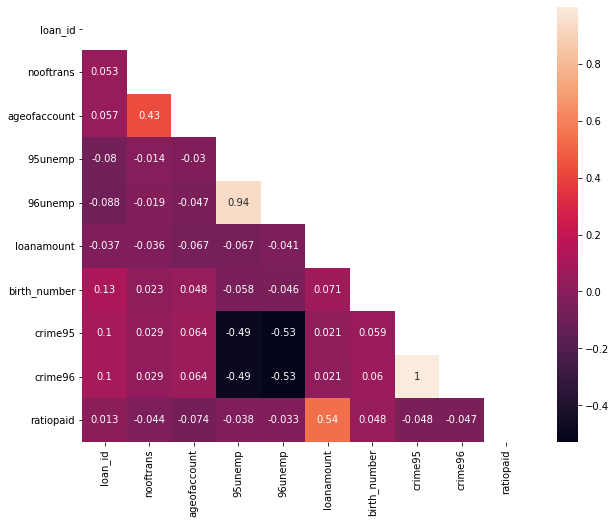

In [19]:

corr_matrix = df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True )


### Clean and wrangling steps 

In [20]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
#bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 
# feature engineering - take the columns and make more useful 

# split the data into num and cat --- > diff options cleaning / scaling

In [21]:
df.drop(['loan_id', 'type'], axis=1, inplace=True) 

In [22]:
df['crime_sum'] = df['crime95'] + df['crime96']

In [23]:
df.drop(['crime95', 'crime96'], axis=1, inplace=True)

In [24]:
df.head()

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type,crime_sum
0,goodloans,191,2134,0.29,0.43,80952,450204,0.96,,184784
1,goodloans,32,2134,0.29,0.43,80952,450204,0.96,SIPO,184784
2,goodloans,65,2134,0.29,0.43,80952,450204,0.96,SLUZBY,184784
3,goodloans,70,2134,0.29,0.43,80952,450204,0.96,UROK,184784
4,goodloans,16,2134,0.29,0.43,80952,450204,0.96,UVER,184784


### Pre processing 

In [25]:
# label / encode categorical columns 
# scale numerical columns 

In [26]:
from sklearn.preprocessing import OrdinalEncoder
# encoding trans type to numeric
ord_enc = OrdinalEncoder()
df["trans_type"] = ord_enc.fit_transform(df[["trans_type"]])
df.head(20)

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type,crime_sum
0,goodloans,191,2134,0.29,0.43,80952,450204,0.96,0.0,184784
1,goodloans,32,2134,0.29,0.43,80952,450204,0.96,4.0,184784
2,goodloans,65,2134,0.29,0.43,80952,450204,0.96,5.0,184784
3,goodloans,70,2134,0.29,0.43,80952,450204,0.96,6.0,184784
4,goodloans,16,2134,0.29,0.43,80952,450204,0.96,7.0,184784
5,badloans,89,1364,1.51,2.07,30276,395423,0.92,0.0,4653
6,badloans,8,1364,1.51,2.07,30276,395423,0.92,3.0,4653
7,badloans,26,1364,1.51,2.07,30276,395423,0.92,4.0,4653
8,badloans,40,1364,1.51,2.07,30276,395423,0.92,5.0,4653
9,badloans,90,1364,1.51,2.07,30276,395423,0.92,6.0,4653


In [27]:
df['trans_type'].value_counts()

6.0    682
5.0    682
7.0    674
0.0    643
4.0    468
2.0    114
3.0     80
1.0     39
Name: trans_type, dtype: int64

In [57]:
#cat
cat = df.select_dtypes(include=object)
cat.head(10)

,status
0,goodloans
1,goodloans
2,goodloans
3,goodloans
4,goodloans
5,badloans
6,badloans
7,badloans
8,badloans
9,badloans


In [38]:
categorical = pd.get_dummies(cat, columns=['status'], drop_first=True)
categorical.head(20)

,status_goodloans
0,1
1,1
2,1
3,1
4,1
5,0
6,0
7,0
8,0
9,0


In [30]:
# numerical scaling
from sklearn.preprocessing import Normalizer

In [31]:
X = df.select_dtypes(include=np.number)
X.head()

,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type,crime_sum
0,191,2134,0.29,0.43,80952,450204,0.96,0.0,184784
1,32,2134,0.29,0.43,80952,450204,0.96,4.0,184784
2,65,2134,0.29,0.43,80952,450204,0.96,5.0,184784
3,70,2134,0.29,0.43,80952,450204,0.96,6.0,184784
4,16,2134,0.29,0.43,80952,450204,0.96,7.0,184784


In [33]:
scaler = Normalizer().fit(X)
scaled = scaler.transform(X) # scaling to gaussian distr
scaled_X = pd.DataFrame(scaled) # convert back to DF
scaled_X.head()


,0,1,2,3,4,5,6,7,8
0,0.000387,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000000,0.374555
1,0.000065,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000008,0.374555
2,0.000132,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000010,0.374555
3,0.000142,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000012,0.374555
4,0.000032,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000014,0.374555


In [34]:
# if there are more categorical values, we have to concat back to the DF
# scaled_X = pd.concat([scaled_X, categorical['trans_type']], axis=1)

### split off the dependant variable (label)

In [39]:
# Y is a dependent variable (status)
y = categorical['status_goodloans']
X = scaled_X

In [47]:
X.head()

,0,1,2,3,4,5,6,7,8
0,0.000387,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000000,0.374555
1,0.000065,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000008,0.374555
2,0.000132,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000010,0.374555
3,0.000142,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000012,0.374555
4,0.000032,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000014,0.374555


In [49]:
y.head(20)

0     1
1     1
2     1
3     1
4     1
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    1
13    1
14    1
15    1
16    1
17    0
18    0
19    0
Name: status_goodloans, dtype: uint8

### train test split, get LOG REG model

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=40) #def train and test sets

## apply model and train model 

In [52]:
classification = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train) # training

### evaluate accuracy and test 

In [53]:
probabilities = classification.predict_proba(X_test)
preds = probabilities[:,1] # part of the array of predictions
import sklearn.metrics as metrics
fpr, tpr, treshold = metrics.roc_curve(y_test, preds) #fpr=FalsePositiveRate, tpr=TruePositiveRate, auc=AreaUnderTheCurve 
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6546557086172774

#### next steps

+ Visualise the accuracy of the predictions in some ways 

+ also think about - is there something I could do to improve my model accuracy?? 

### visualising accuracy - ROC / AUC 

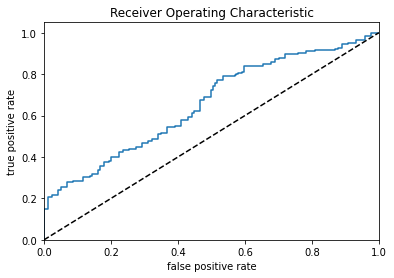

In [54]:
#roc curve plot 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC'%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()


### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [55]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

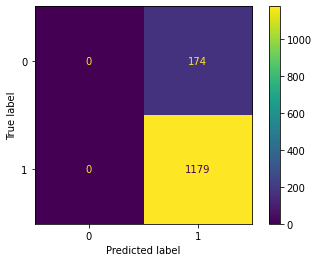

In [56]:
predictions = classification.predict(X_test)
accuracy_score(y_test, predictions)
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)

### data is highly imbalanced

this is affecting the accuracy of our predictions 
- what can be done to resolve that ?


+ option 1 - SMOTE 

+ option 2 - TOMEK LINKS 

